In [1]:
pwd

'/mnt/md0/isshamie/Projects/Mito_Trace/src/vireo'

In [2]:
# INDIR="/data/Mito_Trace/output/pipeline/cd34norm/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat"
# COUNT_INDIR="/data/Mito_Trace/output/pipeline/cd34norm/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_init/donor0"
# OUTDIR= "/data/Mito_Trace/output/pipeline/cd34norm/MTblacklist/results/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/clones_dendro"
# #N_DONORS=4
# DONOR=0
# var_type="init"
#INDIR=""
#sample_names="Control,Flt3l" #"Control,Flt3l,Input"

# INDIR = "/data/Mito_Trace/output/pipeline/cd34norm/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_mgatkdonor/vireo/nclones20"
# OUTDIR = "/data/Mito_Trace/output/pipeline/cd34norm/MTblacklist/results/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_mgatkdonor/vireo/nclones20/clones_dendro"
# DONOR = 3
# COUNT_INDIR = "/data/Mito_Trace/output/pipeline/cd34norm/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_mgatkdonor/donor3/mgatk"
# var_type = "mgatkdonor"

INDIR = "/data/Mito_Trace/output/pipeline/cd34norm/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_simple/vireo/nclones20"
OUTDIR = "/data/Mito_Trace/output/pipeline/cd34norm/MTblacklist/results/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_simple/vireo/nclones20/clones_dendro"
DONOR = 3
COUNT_INDIR = "/data/Mito_Trace/output/pipeline/cd34norm/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/"
var_type = "simple"

In [3]:
#sample_names = {ind:val for ind,val in enumerate(sample_names.split(","))}


In [4]:
from os.path import join, exists, dirname
from glob import glob
import pickle
import mplh.cluster_help as ch
import mplh.fig_utils as fu

import os
import vireoSNP
import numpy as np
from scipy import sparse
from scipy.io import mmread
import matplotlib.pyplot as plt
from scipy.stats import hypergeom
print(vireoSNP.__version__)

import pandas as pd
import seaborn as sns
from vireoSNP import Vireo
np.set_printoptions(formatter={'float': lambda x: format(x, '.5f')})

0.5.6


# Clonal reconstruction with mitochondrial mutations results

The mitochondrial mutations data set is extracted from [Ludwig et al, Cell, 2019](https://doi.org/10.1016/j.cell.2019.01.022), the 9 variants used here are from Supp Fig. 2F (and main Fig. 2F).

For clonal reconstruction, we are using the core class `vireoSNP.Vireo` with multiple initializations

## Load cluster results and plot dendrograms

In [5]:
import seaborn as sns
from mplh import cluster_help as ch

In [6]:
out_f = join(OUTDIR, f"donor{DONOR}")


if var_type == "init":
    curr_af_f = join(COUNT_INDIR, "af.tsv")
    curr_dp_f = join(COUNT_INDIR, "dp.tsv")
    AF_df = pd.read_csv(curr_af_f, sep="\t", index_col=0).transpose()
    DP_df = pd.read_csv(curr_dp_f, sep="\t", index_col=0).transpose()
elif var_type=="simple":
    curr_ad_f = join(COUNT_INDIR, f"donor{DONOR}.AD.mtx")
    curr_dp_f = join(COUNT_INDIR, f"donor{DONOR}.DP.mtx")
    from src.utils.data_io import wrap_load_mtx_df
    AF_df, DP_df = wrap_load_mtx_df(COUNT_INDIR, prefix=f"donor{DONOR}", 
                                    vcf_prefix=f"donor{DONOR}", inc_af=True, cell_names=True, 
                                    cells_meta= f"cell_labels.donor{DONOR}.txt", cells_meta_sep=',')
elif var_type=="mgatkdonor":
    curr_af_f = join(COUNT_INDIR, f"d{DONOR}.af.tsv")
    curr_dp_f = join(COUNT_INDIR, f"d{DONOR}.coverage.tsv")
    AF_df = pd.read_csv(curr_af_f, sep="\t")
    DP_df = pd.read_csv(curr_dp_f, sep="\t")

DP_df.index.name = "Variant"
DP_df.columns.name = "Cell"
AF_df.index.name = "Variant"
AF_df.columns.name = "Cell"

ic| prefix: 'donor3'


In [7]:
print(AF_df.shape)
AF_df.head()

(709, 3751)


Cell,AAACGAAAGAGGTCCA-1_Control,AAACGAACAATAGTGA-1_Control,AAACGAACATCGTGAT-1_Control,AAACGAAGTAACGGTG-1_Control,AAACGAATCGAGCGCT-1_Control,AAACGAATCGCGCTGA-1_Control,AAACTCGAGATTACGA-1_Control,AAACTGCAGCATGTGG-1_Control,AAACTGCAGTATAGTG-1_Control,AAACTGCCAGCAACAG-1_Control,...,TTTGGCCGTACAAATG-1_Flt3l,TTTGGCCTCAGGTCTA-1_Flt3l,TTTGGCCTCCCTAAAG-1_Flt3l,TTTGGCCTCTATCTTG-1_Flt3l,TTTGGTTAGTCCGTGC-1_Flt3l,TTTGGTTGTTAACCAC-1_Flt3l,TTTGTGTAGAGAGTAG-1_Flt3l,TTTGTGTGTATTCTGG-1_Flt3l,TTTGTGTTCGTTACAG-1_Flt3l,TTTGTGTTCTCCTTGG-1_Flt3l
Variant,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.000000,0.050,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.0
1,0.0,0.0,0.000000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.04878,0.0,0.0
2,0.0,0.0,0.000000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.0
3,1.0,1.0,0.996604,0.875,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.833333,0.999999,1.0,0.999999,0.974359,1.00000,1.0,1.0
4,0.0,0.0,0.000000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.0


In [8]:
print(DP_df.shape)
DP_df.head()

(709, 3751)


Cell,AAACGAAAGAGGTCCA-1_Control,AAACGAACAATAGTGA-1_Control,AAACGAACATCGTGAT-1_Control,AAACGAAGTAACGGTG-1_Control,AAACGAATCGAGCGCT-1_Control,AAACGAATCGCGCTGA-1_Control,AAACTCGAGATTACGA-1_Control,AAACTGCAGCATGTGG-1_Control,AAACTGCAGTATAGTG-1_Control,AAACTGCCAGCAACAG-1_Control,...,TTTGGCCGTACAAATG-1_Flt3l,TTTGGCCTCAGGTCTA-1_Flt3l,TTTGGCCTCCCTAAAG-1_Flt3l,TTTGGCCTCTATCTTG-1_Flt3l,TTTGGTTAGTCCGTGC-1_Flt3l,TTTGGTTGTTAACCAC-1_Flt3l,TTTGTGTAGAGAGTAG-1_Flt3l,TTTGTGTGTATTCTGG-1_Flt3l,TTTGTGTTCGTTACAG-1_Flt3l,TTTGTGTTCTCCTTGG-1_Flt3l
Variant,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,40,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,41,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,134,124,589,32,31,61,196,95,223,41,...,32,110,12,14,59,10,78,44,209,71
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# #for n in range(N_DONORS):
# print(curr_ad_f)
# print(curr_dp_f)
# curr_ad = mmread(curr_ad_f).tocsc()
# curr_dp = mmread(curr_dp_f).tocsc()
# AD_df = pd.DataFrame(curr_ad.todense())
# AD_df.index.name = "Variant"
# AD_df.columns.name = "Cell"
# DP_df = pd.DataFrame(curr_dp.todense())
# DP_df.index.name = "Variant"
# DP_df.columns.name = "Cell"
# AF_df = AD_df/(DP_df+0.001)

In [10]:
cells_meta = pd.read_csv(join(INDIR, "cells_meta.tsv"), sep='\t')#.sort_values(["donor", "lineage"])
# if "donor_index" in cells_meta.columns and "lineage_index" in cells_meta.columns:
#     cells_meta = cells_meta.sort_values(["donor_index", "lineage_index"])
#AD_df = pd.merge(AD_df, vcf[["#CHROM", "POS", "ALT"]], how="inner", left_index=True,right_index=True).set_index(["#CHROM", "POS", "ALT"])
curr_labels = cells_meta[cells_meta["donor"]==DONOR]
curr_labels

,Unnamed: 0,level_0,index,ID,raw ID,new index,condition,donor,donor_index,lineage,lineage_index
11131,0,0,0,AAACGAAAGAGGTCCA-1_Control,AAACGAAAGAGGTCCA-1,1,Control,3,1,NaN,NaN
11132,1,3,3,AAACGAACAATAGTGA-1_Control,AAACGAACAATAGTGA-1,4,Control,3,2,11.0,1.0
11133,2,7,7,AAACGAACATCGTGAT-1_Control,AAACGAACATCGTGAT-1,8,Control,3,3,9.0,1.0
11134,3,8,8,AAACGAAGTAACGGTG-1_Control,AAACGAAGTAACGGTG-1,9,Control,3,4,NaN,NaN
11135,4,13,13,AAACGAATCGAGCGCT-1_Control,AAACGAATCGAGCGCT-1,14,Control,3,5,7.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
14877,3746,17371,17371,TTTGGTTGTTAACCAC-1_Flt3l,TTTGGTTGTTAACCAC-1,17372,Flt3l,3,3747,NaN,NaN
14878,3747,17378,17378,TTTGTGTAGAGAGTAG-1_Flt3l,TTTGTGTAGAGAGTAG-1,17379,Flt3l,3,3748,NaN,NaN
14879,3748,17394,17394,TTTGTGTGTATTCTGG-1_Flt3l,TTTGTGTGTATTCTGG-1,17395,Flt3l,3,3749,NaN,NaN
14880,3749,17404,17404,TTTGTGTTCGTTACAG-1_Flt3l,TTTGTGTTCGTTACAG-1,17405,Flt3l,3,3750,NaN,NaN


In [11]:
def calc_mean(cells, af):
    #print(cells.head())
    return af.loc[:,cells["ID"].values].mean(axis=1)
#     if 'donor_index' in cells.columns:
#         return af.iloc[:, cells['donor_index'].values-1].mean(axis=1)
#     else:
#         return af.mean(axis=1)
    

na shape (2, 709)
clustering
cmap None


/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


clustering
cmap None
clustering
cmap None


/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


clustering
cmap None
clustering
cmap None


/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


clustering
cmap None
clustering
cmap None


/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


clustering
cmap None


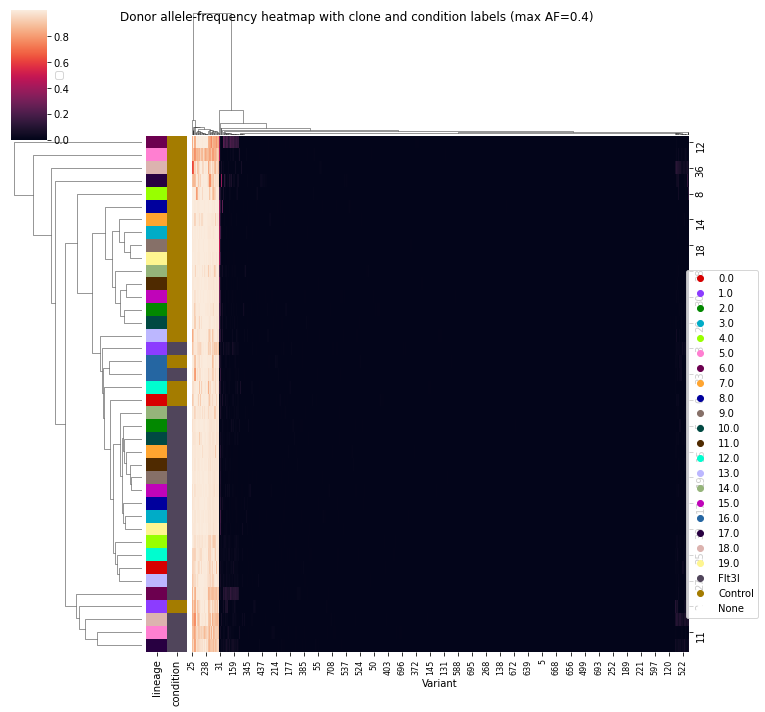

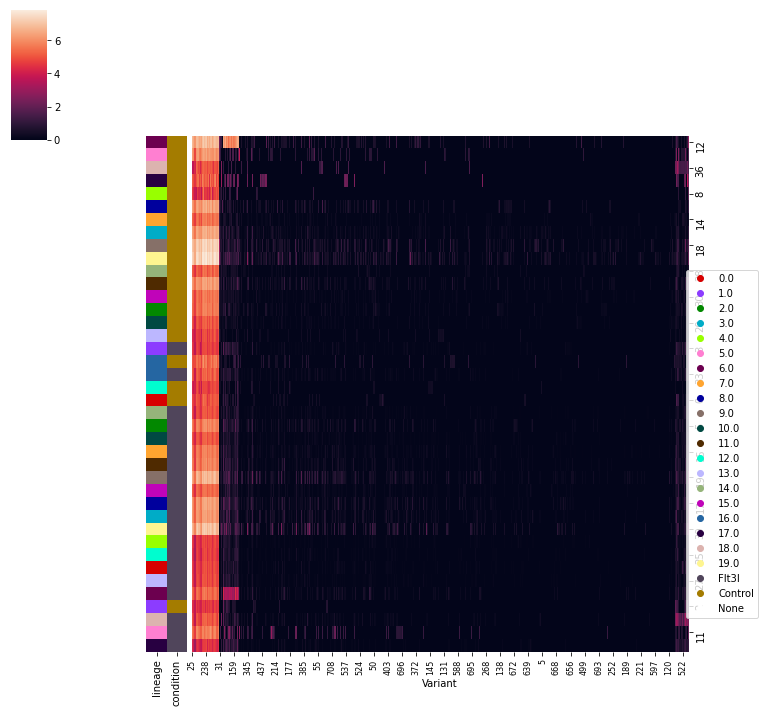

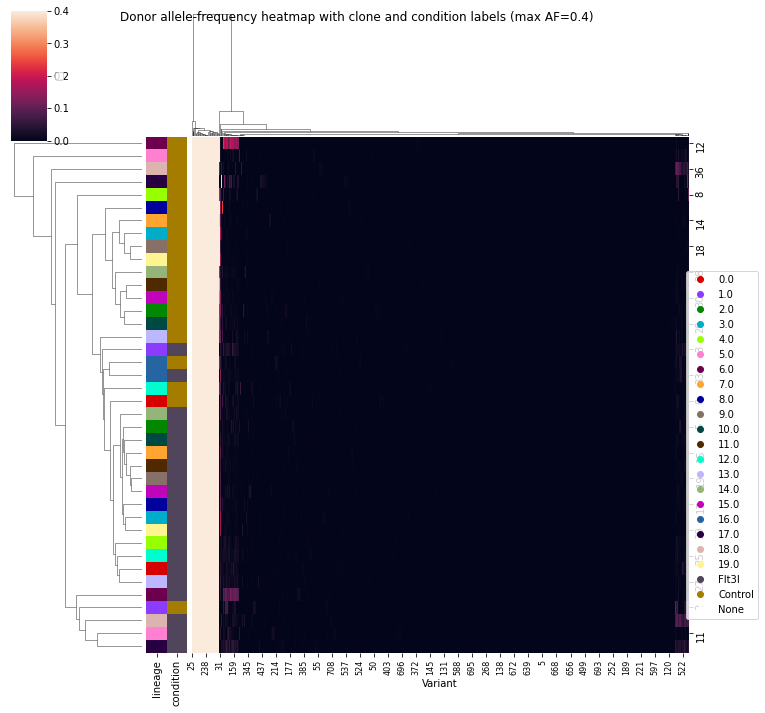

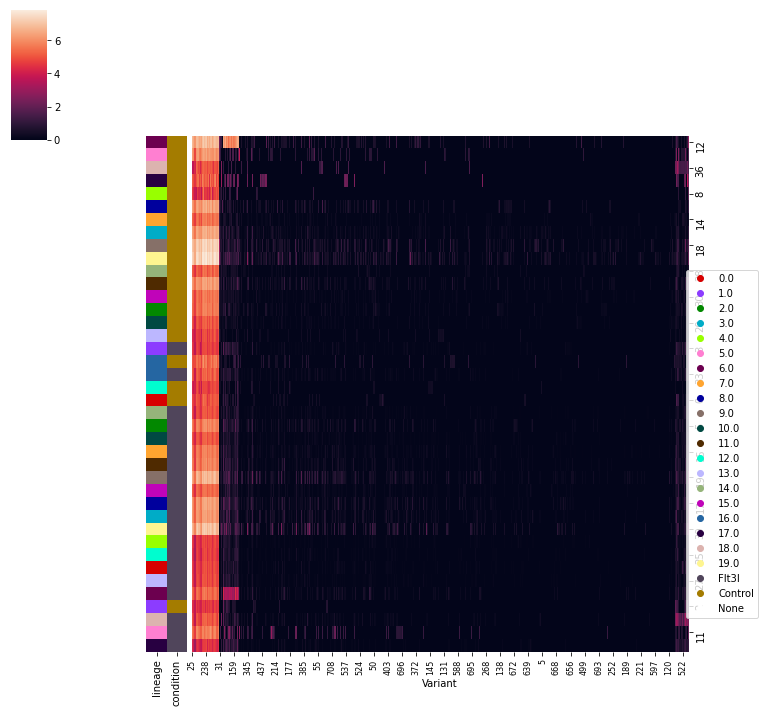

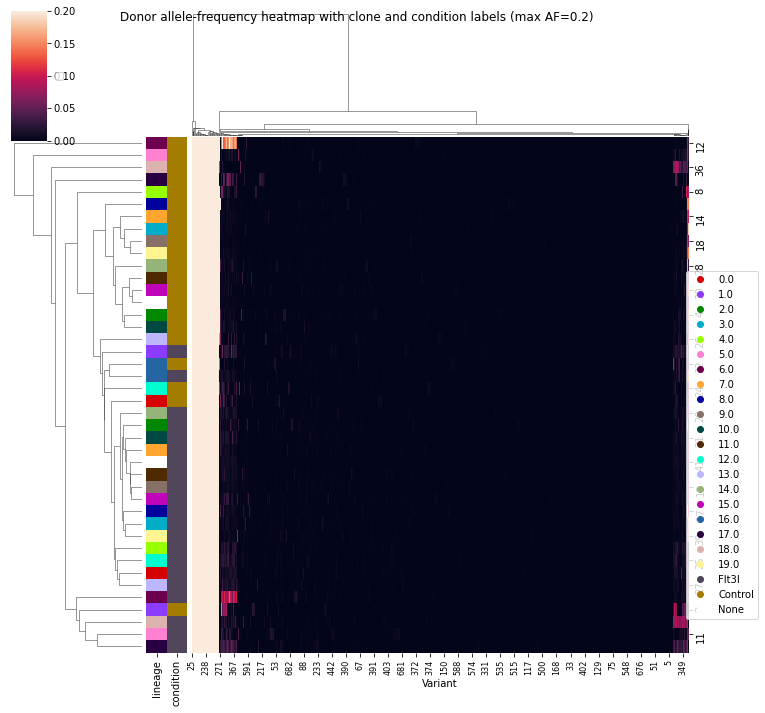

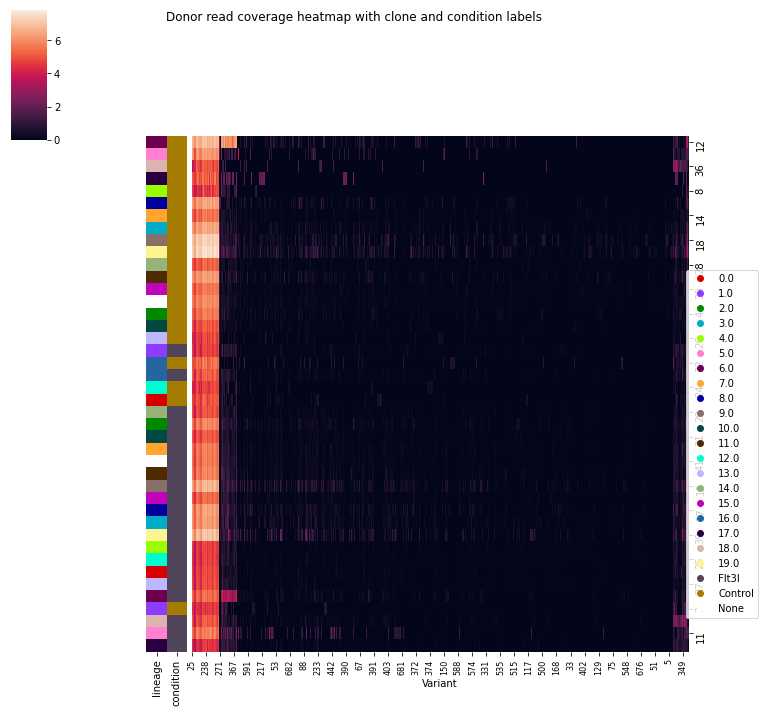

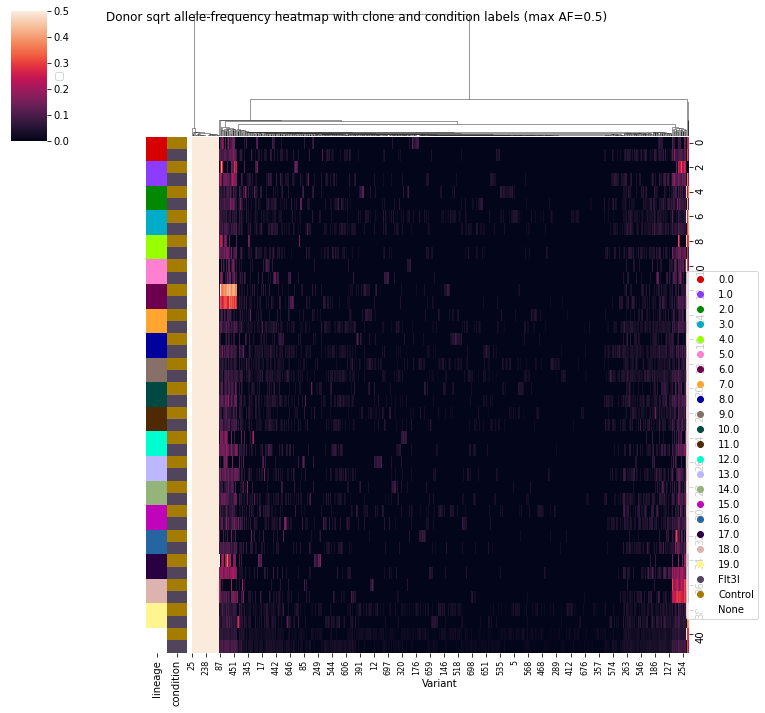

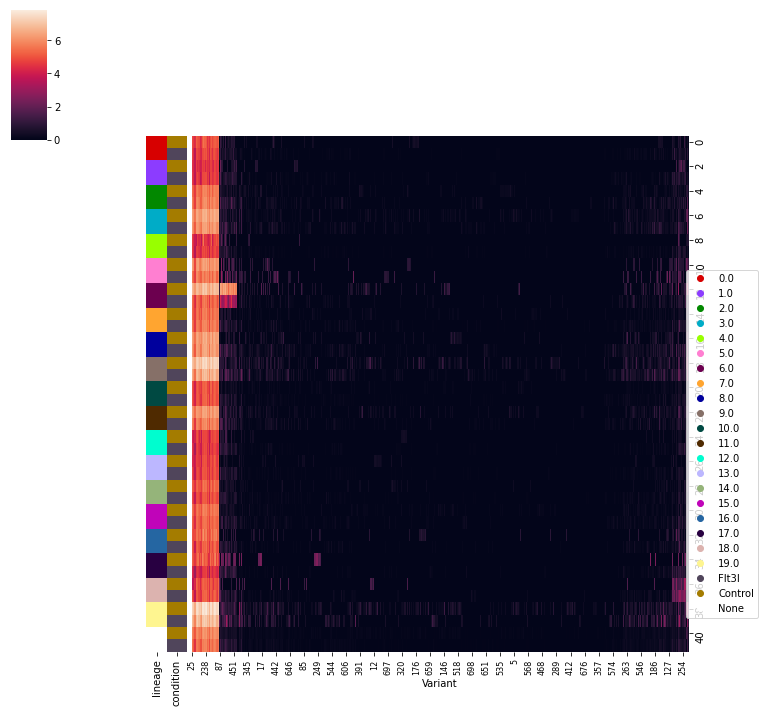

In [12]:
mean_af = curr_labels.groupby(["lineage", "condition"]).apply(calc_mean, af=AF_df)
anno = mean_af.reset_index()[["lineage", "condition"]]

#mean_dp = curr_labels.groupby(["lineage", "condition"]).apply(calc_mean, af=nlog2(DP_df))
mean_dp = curr_labels.groupby(["lineage", "condition"]).apply(calc_mean, af=np.log2(DP_df+1))
anno_dp = mean_dp.reset_index()[["lineage", "condition"]]
mean_dp = mean_dp.reset_index(drop=True)

na_cells = curr_labels.loc[curr_labels["lineage"].isnull()]
na_mean_af = na_cells.groupby("condition").apply(calc_mean, af=AF_df)

if not (na_mean_af.shape[0] == 0):
    print('na shape', na_mean_af.shape)
    na_anno = pd.concat((anno,pd.DataFrame({"lineage":["None"]*len(na_mean_af.index), "condition":na_mean_af.index})), 
                        ignore_index=True)
    na_concat = pd.concat((mean_af.reset_index(drop=True), na_mean_af.reset_index(drop=True)), ignore_index=True)
    na_mean_dp = na_cells.groupby("condition").apply(calc_mean, af=np.log2(DP_df+1))
    na_dp_concat = pd.concat((mean_dp, na_mean_dp.reset_index(drop=True)), ignore_index=True)
else:
    na_anno = anno
    na_concat = mean_af.reset_index(drop=True)
    na_dp_concat = mean_dp
     
    
################
## Plotting
################
## 1.
g1 = ch.plot_cluster((mean_af.reset_index(drop=True)), row_meta=anno, #curr_labels[["condition", "lineage"]], 
                    to_row_clust=True, to_col_clust=True)
g1.figure.suptitle("Donor allele-frequency heatmap with clone and condition labels (max AF=0.4)")
plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
fu.helper_save(out_f+".raw.clust.AF.png", f=g1.figure)

inds = g1.dendrogram_row.dendrogram["leaves"]
cols = g1.dendrogram_col.dendrogram["leaves"]
g1d = ch.plot_cluster(mean_dp.iloc[inds, cols], to_row_clust=False, to_col_clust=False, 
                        row_meta=anno_dp.iloc[inds])
fu.helper_save(out_f+".raw.clust.DP.png", f=g1d.figure)


# ## 2.
g2 = ch.plot_cluster((mean_af.reset_index(drop=True)), row_meta=anno, #curr_labels[["condition", "lineage"]], 
                    to_row_clust=True, to_col_clust=True, vmax=0.4, vmin=0)
plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
g2.figure.suptitle("Donor allele-frequency heatmap with clone and condition labels (max AF=0.4)")
fu.helper_save(out_f+".raw.clust.max4.AF.png")
inds = g2.dendrogram_row.dendrogram["leaves"]
cols = g2.dendrogram_col.dendrogram["leaves"]
ch.plot_cluster(mean_dp.iloc[inds,cols], to_row_clust=False, to_col_clust=False, 
                        row_meta=anno_dp.iloc[inds])
fu.helper_save(out_f+".raw.clust.max4.DP.png")


## 3.
g = ch.plot_cluster(na_concat, row_meta=na_anno, #curr_labels[["condition", "lineage"]], 
                    to_row_clust=True, to_col_clust=True, vmax=0.2, vmin=0)
plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
plt.suptitle("Donor allele-frequency heatmap with clone and condition labels (max AF=0.2)")
fu.helper_save(out_f+".na.clust.max2.AF.png")

inds = g.dendrogram_row.dendrogram["leaves"]
cols = g.dendrogram_col.dendrogram["leaves"]
ch.plot_cluster(na_dp_concat.iloc[inds,cols], to_row_clust=False, to_col_clust=False, 
                        row_meta=na_anno.iloc[inds])
plt.suptitle("Donor read coverage heatmap with clone and condition labels ")
fu.helper_save(out_f+".na.clust.max2.DP.png")


# ## 4.
g = ch.plot_cluster(np.sqrt(na_concat), row_meta=na_anno, #curr_labels[["condition", "lineage"]], 
                    to_row_clust=False, to_col_clust=True, vmax=0.5, vmin=0)
plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
plt.suptitle("Donor sqrt allele-frequency heatmap with clone and condition labels (max AF=0.5)")
fu.helper_save(out_f+".na.max5.AF.png")
#inds = g.dendrogram_row.dendrogram["leaves"]
cols = g.dendrogram_col.dendrogram["leaves"]
ch.plot_cluster(na_dp_concat.iloc[:,cols], to_row_clust=False, to_col_clust=False, 
                        row_meta=na_anno.iloc[inds])
fu.helper_save(out_f+".na.max5.DP.png")

#plt.close('all')

# Do the same but not grouping by condition

na shape (2, 709)
clustering
cmap None


/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


clustering
cmap None
clustering
cmap None


/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


clustering
cmap None
clustering
cmap None


/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


clustering
cmap None
clustering
cmap None


/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


clustering
cmap None


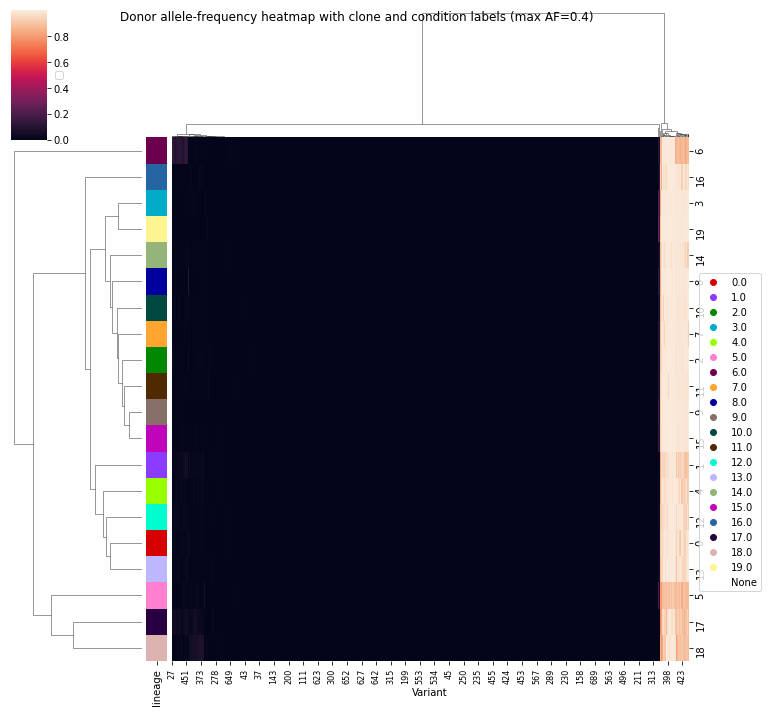

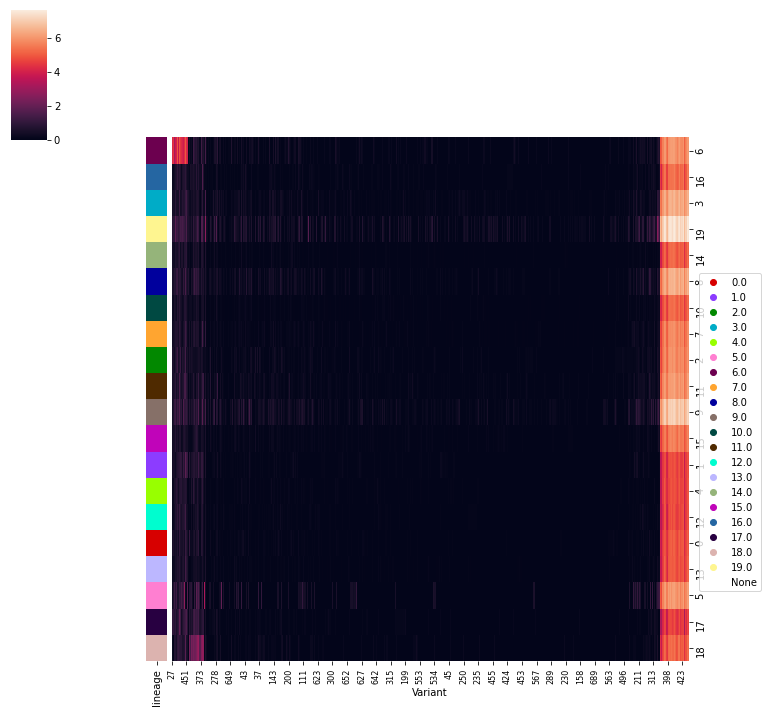

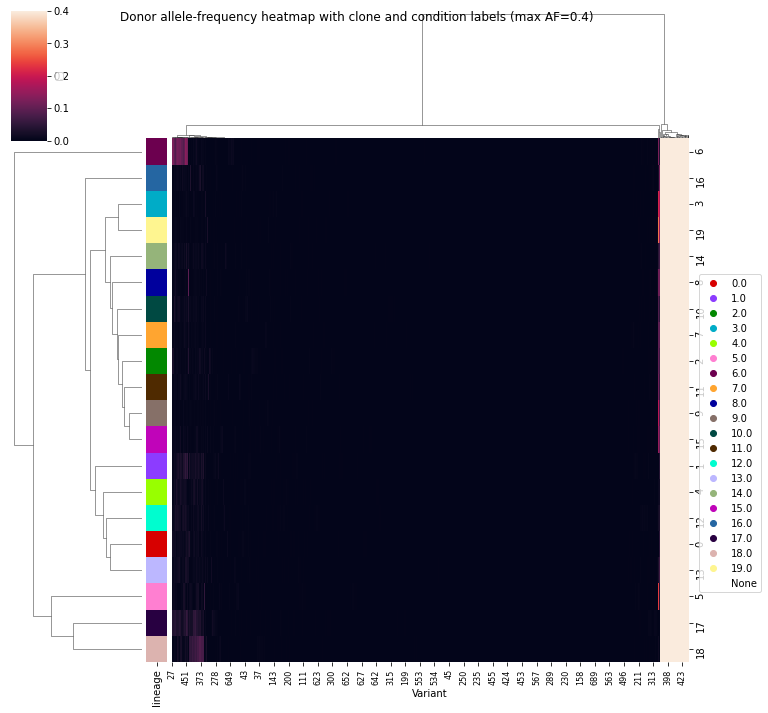

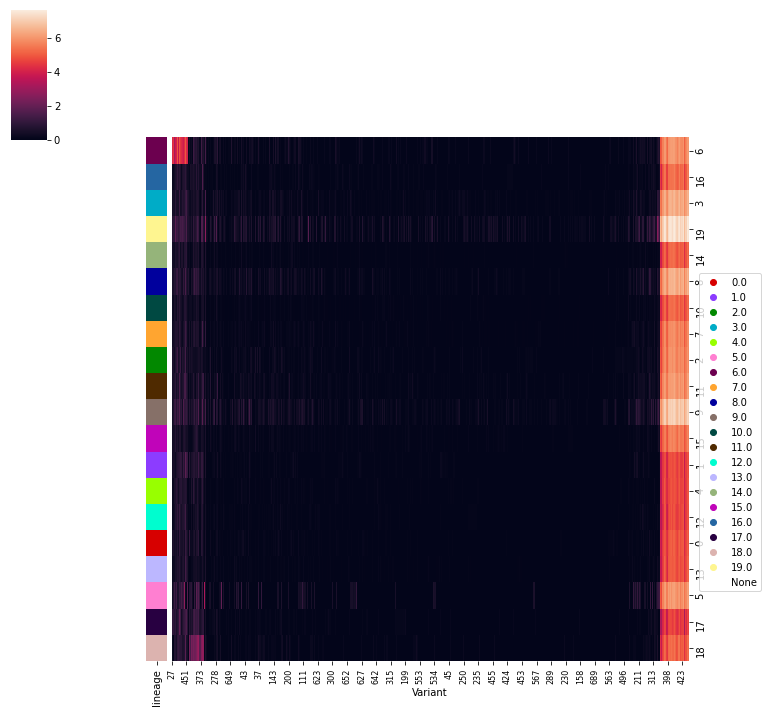

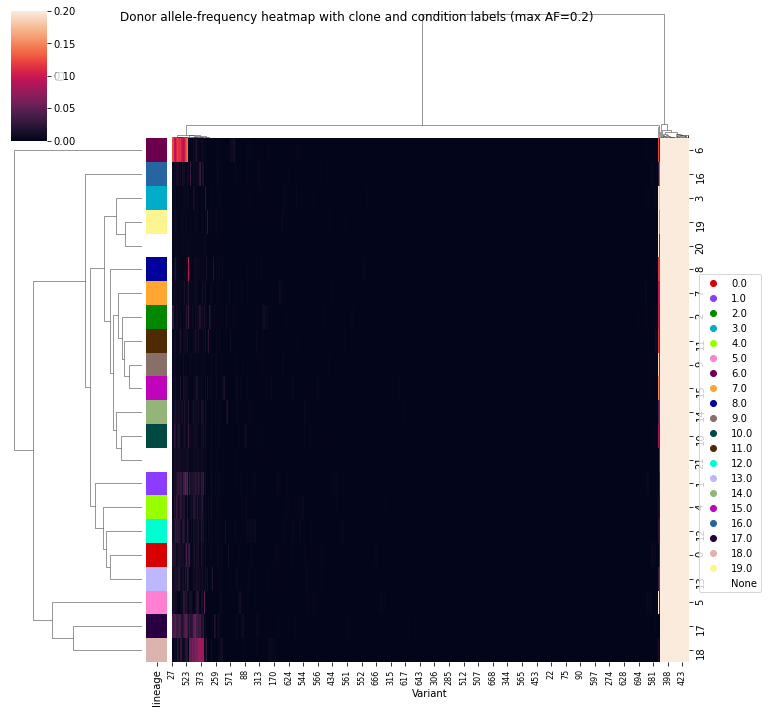

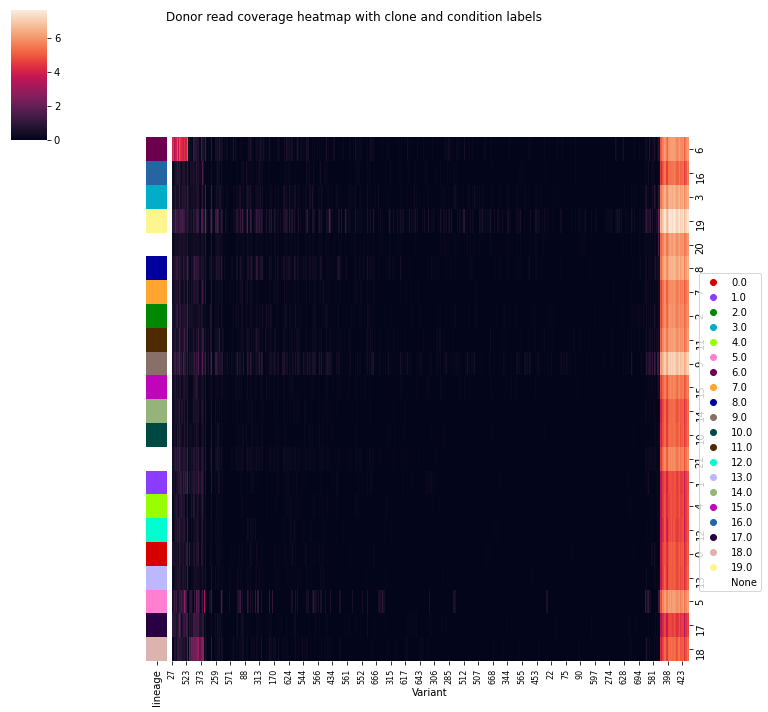

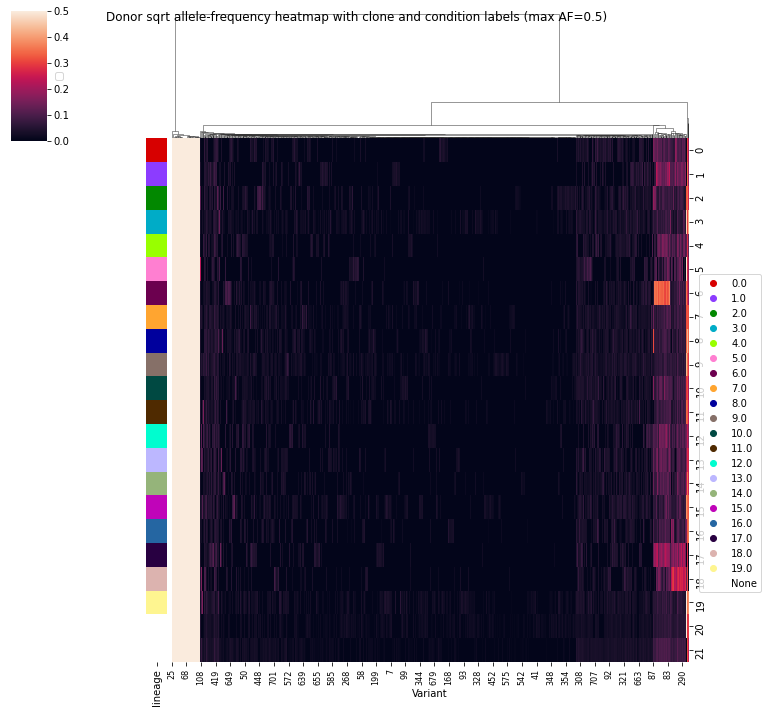

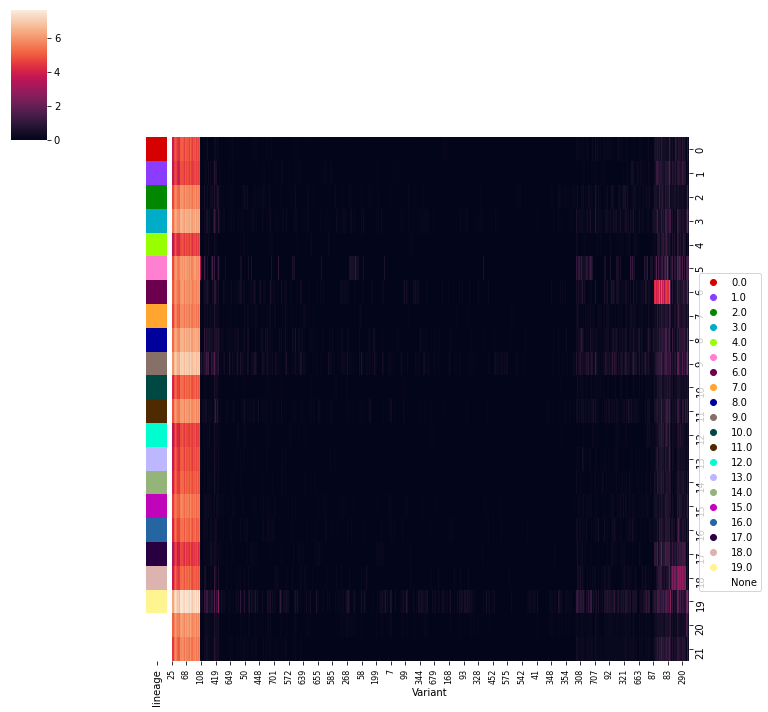

In [13]:
mean_af = curr_labels.groupby(["lineage"]).apply(calc_mean, af=AF_df)
anno = mean_af.reset_index()[["lineage"]]

#mean_dp = curr_labels.groupby(["lineage"]).apply(calc_mean, af=nlog2(DP_df))
mean_dp = curr_labels.groupby(["lineage"]).apply(calc_mean, af=np.log2(DP_df+1))
anno_dp = mean_dp.reset_index()[["lineage"]]
mean_dp = mean_dp.reset_index(drop=True)

na_cells = curr_labels.loc[curr_labels["lineage"].isnull()]
na_mean_af = na_cells.groupby("condition").apply(calc_mean, af=AF_df)

if not (na_mean_af.shape[0] == 0):
    print('na shape', na_mean_af.shape)
    na_anno = pd.concat((anno,pd.DataFrame({"lineage":["None"]*len(na_mean_af.index)})), ignore_index=True)
    na_concat = pd.concat((mean_af.reset_index(drop=True), na_mean_af.reset_index(drop=True)), ignore_index=True)
    na_mean_dp = na_cells.groupby("condition").apply(calc_mean, af=np.log2(DP_df+1))
    na_dp_concat = pd.concat((mean_dp, na_mean_dp.reset_index(drop=True)), ignore_index=True)
else:
    na_anno = anno
    na_concat = mean_af.reset_index(drop=True)
    na_dp_concat = mean_dp
     
    
################
## Plotting
################
## 1.
g1 = ch.plot_cluster((mean_af.reset_index(drop=True)), row_meta=anno, #curr_labels[["condition", "lineage"]], 
                    to_row_clust=True, to_col_clust=True)
g1.figure.suptitle("Donor allele-frequency heatmap with clone and condition labels (max AF=0.4)")
plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
fu.helper_save(out_f+".NoCondition.raw.clust.AF.png", f=g1.figure)

inds = g1.dendrogram_row.dendrogram["leaves"]
cols = g1.dendrogram_col.dendrogram["leaves"]
g1d = ch.plot_cluster(mean_dp.iloc[inds, cols], to_row_clust=False, to_col_clust=False, 
                        row_meta=anno_dp.iloc[inds])
fu.helper_save(out_f+".NoCondition.raw.clust.DP.png", f=g1d.figure)


# ## 2.
g2 = ch.plot_cluster((mean_af.reset_index(drop=True)), row_meta=anno, #curr_labels[["condition", "lineage"]], 
                    to_row_clust=True, to_col_clust=True, vmax=0.4, vmin=0)
plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
g2.figure.suptitle("Donor allele-frequency heatmap with clone and condition labels (max AF=0.4)")
fu.helper_save(out_f+".NoCondition.raw.clust.max4.AF.png")
inds = g2.dendrogram_row.dendrogram["leaves"]
cols = g2.dendrogram_col.dendrogram["leaves"]
ch.plot_cluster(mean_dp.iloc[inds,cols], to_row_clust=False, to_col_clust=False, 
                        row_meta=anno_dp.iloc[inds])
fu.helper_save(out_f+".NoCondition.raw.clust.max4.DP.png")


## 3.
g = ch.plot_cluster(na_concat, row_meta=na_anno, #curr_labels[["condition", "lineage"]], 
                    to_row_clust=True, to_col_clust=True, vmax=0.2, vmin=0)
plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
plt.suptitle("Donor allele-frequency heatmap with clone and condition labels (max AF=0.2)")
fu.helper_save(out_f+".NoCondition.na.clust.max2.AF.png")

inds = g.dendrogram_row.dendrogram["leaves"]
cols = g.dendrogram_col.dendrogram["leaves"]
ch.plot_cluster(na_dp_concat.iloc[inds,cols], to_row_clust=False, to_col_clust=False, 
                        row_meta=na_anno.iloc[inds])
plt.suptitle("Donor read coverage heatmap with clone and condition labels ")
fu.helper_save(out_f+".NoCondition.na.clust.max2.DP.png")


# ## 4.
g = ch.plot_cluster(np.sqrt(na_concat), row_meta=na_anno, #curr_labels[["condition", "lineage"]], 
                    to_row_clust=False, to_col_clust=True, vmax=0.5, vmin=0)
plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
plt.suptitle("Donor sqrt allele-frequency heatmap with clone and condition labels (max AF=0.5)")
fu.helper_save(out_f+".NoCondition.na.max5.AF.png")
#inds = g.dendrogram_row.dendrogram["leaves"]
cols = g.dendrogram_col.dendrogram["leaves"]
ch.plot_cluster(na_dp_concat.iloc[:,cols], to_row_clust=False, to_col_clust=False, 
                        row_meta=na_anno.iloc[inds])
fu.helper_save(out_f+".NoCondition.na.max5.DP.png")

#plt.close('all')